05.20.19: 
- Uses updated csv with Carrie's latest data set that uses a different binning scheme.
- only using random forest now
- first summer meeting with Max and Joe
> * Carrie mentioned getting initial data for one year and comparing it to the cleaned data for the same year to determine if we really need to do noise removal <br>
> - send email to Carrie, formatting same as newest csv
> * completing a few years a data to see if model still holds <br>
> * creating graphs to show satellite data does indeed help <br>
> * let Max know if there are any formatting issues <br>
> * paper:
>> - ocean people or machine learning people?
>> - email thread with Kris and Carrie to see where they see it going
>> - research article (short end ~ 3,000 word ISH)
>> - outline: data sources, what did we do with those data, researchs (figures), then do discussion and intro
>> - interdisciplinary research > limited jargon
> * Max: looking at NA values in distnace from shore in new csv


06.30.19:
- formatting issues with new csv files:
> * excel and 'use engine python' error <br>
> * str error of '10:00:03' (example) in <br>
> x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1) <br>
  x[:] = preprocessing.scale(x) # [:] retains dataframe <br>
> * gitbash .. less
> * NAN values in depth bins (file 2019-05-29_2013)
- presentation on Wed for NOAA Fisheries
> * what feedback would be useful for me?
> * other ways to apply similar approaches (narrow slice of looking at log NASC or generalized approacheds?
> * how would this relate to stuff they are working on (their work, what they are tyring to do)?
> * let's suppose this approahc is feasbile, what could they actually do with this info? what opportunities would this open up that are currently available
> * aggregate mseausre of log NASC, can we get to something that more directly represents biomass or fish stocks rather than log NASC. How do we make this leap from log NASC to biomass?
> * audience: Carris Q 





06.17.19
- make chart for each depth bin (above)
- review paper sent by Max for separating training and testing data
- multiple years: use several years and then predict one year of data by withholding sonar data -> figure out how
> - how does addition of years impact training performance (if any increase in performance?)
> - how much data is enough to get an accurate prediction? 
- nn approaches to update the training by adding data instead of simply retraining each time ???
- look at each individual year and look at appregate of all years
- my new tag line: "that's out of scope for this project"
<br>

* 1. train with 2012 and 2013, predict 2015 <br>
*  1b. subanalysis: train only with 2012 OR 2013 to see how well 2015 can be predicted? (central to message of paper -> helps answer how much data is needed to be an accurate prediction) <br>
> - combine all three years inton 1 df, x/y test into 2015, write new train_test_split function to pull by year <br>
> - does this solve the method of how to spatially separate training data? <br>
*  1c. var imp is secondary to this <br> <br>

* 2. RF analysis that excludes all the MODIS data to predict log NASC
*  2b. RF analysis that excludes depths and sonar data to predict log NASC <br> <br>

* 3. Next steps for next week: read paper from Max (email) to figure out how to separate training and testing data spatially <br>

* github

06.24.2019:
* make function to avoid copy pasta
* method for spatial and temporal distribution for training and testing data - "Wreck it Ralph strategy"
* make a block for North and South to extrapolate the log nasc values for the other (prediction and extrapolation for other regions is the goal here)
> - median lat is 42.3 degrees
> - don't use train_test_split; set each x_train, etc. to csv appropriate rows 
> - don't include lat or lon in sets (rely almost exclusively on sat data but still include depth_m, distance from shore), still include Day from sonar, to predict log NASC values
> - potential problems: over-sampling an area based on time of year, data points are taken over the course of several months, so using North data from May to extrapolate log NASC values for the South in July has temporal issues

* plots: one for when N is held out, one for when the S is held out
* (2 more plots if time) visualize residuals (squared difference between observed and predicted) -> scatter plot (lat on x axis, residuals on y axis)
* powerpoint: include some info from paper Max sent out about why this is a problem (spatial and temporal distribution of data)

In [1]:
# libraries

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os,sys
from rfpimp import oob_dropcol_importances, cv_importances, oob_importances, dropcol_importances, importances, plot_importances
from matplotlib.ticker import FormatStrFormatter
from functools import reduce


In [2]:
## define a function for calculating importances by MSE
def mse(model, X, y, sample_weights=None):
    y_pred = model.predict(X)
    mse = np.sum((y-y_pred)**2) / np.max(y.shape)
    return mse

In [19]:
## previous data organization but with new file
path = "/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-06-03_2013_nasc_sonar.csv"
# 2019-06-03 is updated csv file to fix NAN problem for distance from shore variable, depths

d = pd.read_csv(path)#, nrows=100000) #had trouble getting permissions to read csv while trying to open in excel
print(d.columns)
#print(d['wavelength'])

d = d.query('NASC > 0')  # filter out zero-value NASC
d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
d = d.assign(depth_m = d.depth_m.astype(np.float64))
d = d.query('log_nasc < 17.5')

feats = [
    'Lon', 
    'Lat',
    'distance_from_shore_m',
    'depth_m',
    'log_nasc', 
    'wavelength', 
    'depth_bin',
    'Day'
]
filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
d = d[filter_col]
d = d.dropna()

z = d[['Lat','Lon','closest_sst','closest_chlor_a','distance_from_shore_m','depth_m',\
        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
        'closest_Rrs_667','closest_Rrs_678','Day']]

wavelengths = d.wavelength.unique()
wavelengths.sort()
#wavelengths

depth_bins = d.depth_bin.unique()
#depth_bins.dropna()
#depth_bins
'''
subd = d.query('wavelength == ' + str(wavelengths[0]))
subd = subd.query("depth_bin == '" + str(depth_bins[0]) + "'")
x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
x[:] = preprocessing.scale(x) # [:] retains dataframe
y = subd.log_nasc
x_train, x_test, y_train, y_test = train_test_split(x, y)
'''

Index(['NASC', 'Timestamp', 'date', 'time', 'Sv_mean', 'Sv_min', 'Sv_max',
       'Thickness_mean', 'Range_mean', 'Dist',
       ...
       'closest_Rrs_469', 'closest_Rrs_488', 'closest_Rrs_531',
       'closest_Rrs_547', 'closest_Rrs_555', 'closest_Rrs_645',
       'closest_Rrs_667', 'closest_Rrs_678', 'closest_sst',
       'closest_surface_elevation'],
      dtype='object', length=260)


'\nsubd = d.query(\'wavelength == \' + str(wavelengths[0]))\nsubd = subd.query("depth_bin == \'" + str(depth_bins[0]) + "\'")\nx = subd.drop([\'log_nasc\', \'wavelength\', \'depth_bin\'], axis=1)\nx[:] = preprocessing.scale(x) # [:] retains dataframe\ny = subd.log_nasc\nx_train, x_test, y_train, y_test = train_test_split(x, y)\n'

In [24]:
print(wavelengths.shape)
print("wavelengths: ",wavelengths) # wavelengths = d.wavelength.unique()
print("depth bins: ",depth_bins)
print("file shape: ",d.shape)
#print("file shape with no NAN values: ",(d.dropna()).shape,'\n')
#print(d.columns)
print(d.head())



(5,)
wavelengths:  [ 18  38  70 120 200]
depth bins:  ['deepwater' 'shallowwater' 'shelfwater' 'midwater']
file shape:  (292447, 23)
      Day  wavelength  depth_bin  distance_from_shore_m  depth_m         Lon  \
2412    1         120  deepwater           61876.130927  -3107.0 -125.270695   
2413    1         120  deepwater           64125.225553  -3107.0 -125.293361   
2414    1         120  deepwater           56405.326489  -3000.0 -125.190444   
2415    1         120  deepwater           53545.209019  -2619.0 -125.154178   
2416    1         120  deepwater           49696.187894  -1651.0 -125.105525   

            Lat  closest_chlor_a  closest_nflh  closest_poc    ...     \
2412  42.622922        -0.181167      0.268198   161.781235    ...      
2413  42.607706        -0.310184      0.225154   149.922173    ...      
2414  42.593882        -0.122016      0.279650   166.341110    ...      
2415  42.593703        -0.190391      0.264049   160.643719    ...      
2416  42.593837      

In [21]:
# test df to see number of NAN values for each variable

filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
test = d[filter_col]
list_test = list(test)
#print(list_test)
#test = d.dropna()

instances = test.isna().sum()  # number of instances na occurs in column
print(f"{instances}")
# result: distance from shore is all NA, which should not be happening

Day                          0
wavelength                   0
depth_bin                    0
distance_from_shore_m        0
depth_m                      0
Lon                          0
Lat                          0
closest_chlor_a              0
closest_nflh                 0
closest_poc                  0
closest_Rrs_412              0
closest_Rrs_443              0
closest_Rrs_469              0
closest_Rrs_488              0
closest_Rrs_531              0
closest_Rrs_547              0
closest_Rrs_555              0
closest_Rrs_645              0
closest_Rrs_667              0
closest_Rrs_678              0
closest_sst                  0
closest_surface_elevation    0
log_nasc                     0
dtype: int64


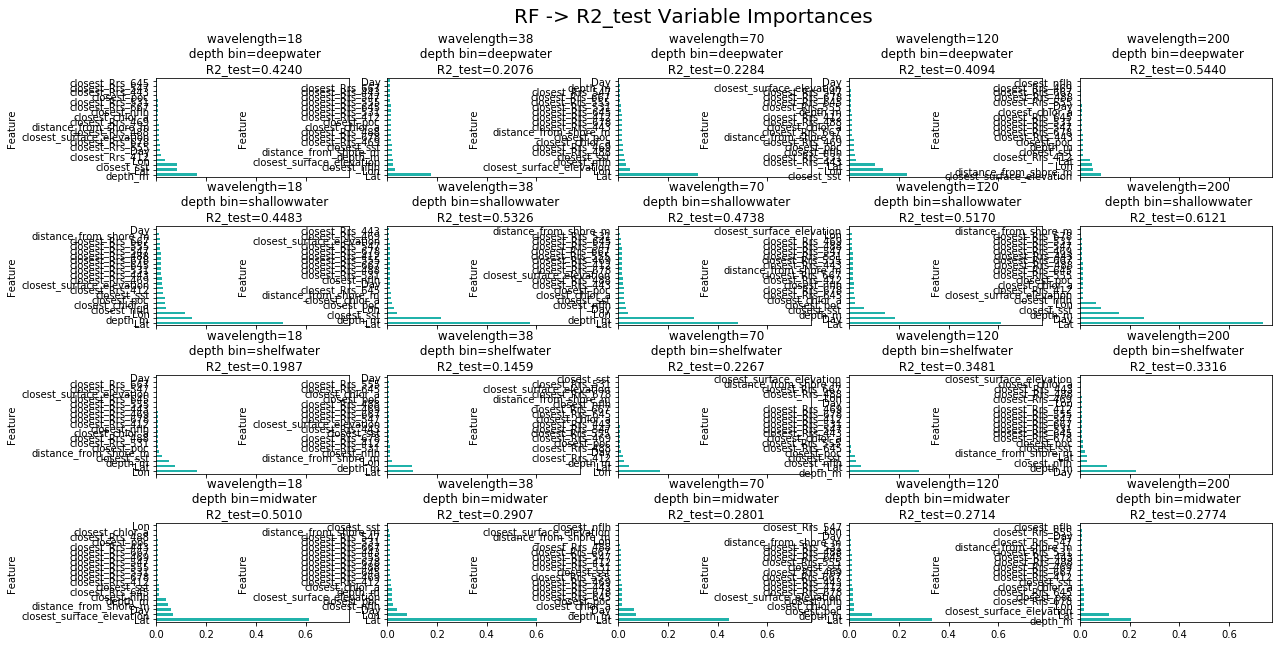

In [28]:
## Random Forest importances

# R2_test
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)
df_list = []
important_features_dict = {}
color = ['lightseagreen']#,'paleturquoise','lightskyblue','darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        rf.fit(x_train, y_train)
        
        ## calculate importances via permutation using model.score()
        perm_imp = importances(rf, x_test, y_test)
        #print(type(perm_imp))
        indices = np.argsort(perm_imp)[::-1]
    
        # add model to lst of dfs...concatenate later
        #change title of columns in df from 'importance_x' to 'model...'
        new_df = perm_imp.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
        df_list.append(new_df)
        
        
        title = "\n wavelength={0}\n depth bin={1}\n R2_test={2:0.4f}".format(wavelengths[i], depth_bins[j], rf.score(x_test, y_test))
        perm_imp.Importance = np.abs(perm_imp.Importance.values)
        perm_imp.Importance.nlargest(len(d.columns)).plot(kind='barh',legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
        axes[j, i].set_title(title)
        
        
plt.subplots_adjust(hspace=0.5)
fig.suptitle('RF -> R2_test Variable Importances \n\n',fontsize=20)
plt.savefig('2019-06-03_RF-R2test_var_importances.png')
plt.show()

In [29]:
# df: sort values descending and ascending values for max avg
from functools import reduce

# make row identifier "column" a real column
for i in df_list:
    i.reset_index(inplace=True)

# sort by mean model importance to determine sort order for plots


#print(df_list[0], (df_list[0]).shape)
reduce(lambda x, y: pd.merge(x, y, on = 'Feature'), df_list)


,Feature,Importance_18_deepwater,Importance_18_shallowwater,Importance_18_shelfwater,Importance_18_midwater,Importance_38_deepwater,Importance_38_shallowwater,Importance_38_shelfwater,Importance_38_midwater,Importance_70_deepwater,...,Importance_70_shelfwater,Importance_70_midwater,Importance_120_deepwater,Importance_120_shallowwater,Importance_120_shelfwater,Importance_120_midwater,Importance_200_deepwater,Importance_200_shallowwater,Importance_200_shelfwater,Importance_200_midwater
0,depth_m,0.163246,0.143892,0.049645,0.040212,-0.020420,0.214878,0.099100,-0.017316,-0.007173,...,0.021295,0.072732,-0.007839,0.143432,0.279273,0.092722,0.010529,0.155549,0.108270,0.206797
1,Lat,0.084425,0.507480,0.073273,0.613954,0.175878,0.574862,0.102772,0.602234,0.322857,...,0.041661,0.446058,0.105550,0.610302,0.048004,0.334861,0.041853,0.737519,0.026030,0.115465
2,closest_sst,0.083484,0.026319,0.022747,-0.008565,-0.018528,0.040482,0.008068,-0.003927,-0.023065,...,-0.000361,-0.011819,0.233889,0.058600,0.023407,-0.011456,0.010556,0.086150,-0.013041,-0.012874
3,Lon,0.032719,0.114771,0.162376,-0.000585,-0.029382,0.026075,0.020520,0.080329,0.045690,...,0.168606,-0.003342,0.137772,0.010336,-0.001544,-0.003405,0.047187,0.064797,-0.007052,-0.015567
4,Day,0.014851,0.001970,-0.001264,0.057019,-0.009598,0.011959,0.003675,0.038797,0.002850,...,0.011317,0.062968,0.002957,0.185147,0.001627,0.004879,0.006649,0.255831,0.226780,0.007702
5,closest_Rrs_555,0.013900,-0.015344,-0.004158,-0.006718,-0.012537,-0.009652,-0.005042,-0.009842,-0.008885,...,-0.007127,-0.012014,-0.007495,-0.014207,-0.004249,-0.011154,0.005680,-0.010653,-0.007630,-0.006485
6,distance_from_shore_m,0.008527,-0.010987,-0.008350,0.044477,-0.018794,0.013471,0.010944,-0.007118,-0.014524,...,0.002692,0.002837,0.012862,-0.015320,-0.000922,0.006196,0.053789,-0.003518,0.021780,-0.008672
7,closest_Rrs_547,0.002140,-0.015375,-0.003214,-0.006516,-0.012144,-0.008714,-0.007044,-0.008811,-0.008024,...,-0.005286,-0.010432,-0.005585,-0.012688,-0.003119,-0.001893,0.007535,-0.008285,-0.007819,-0.008609
8,closest_Rrs_645,-0.001550,-0.018307,-0.004005,-0.009989,-0.012943,-0.012080,-0.005204,-0.011358,-0.010675,...,-0.004810,-0.016458,-0.006879,-0.020976,-0.005490,-0.009961,0.007180,-0.010483,-0.009159,-0.013964
9,closest_Rrs_443,-0.002519,-0.020303,-0.004168,-0.005594,-0.011606,-0.006564,-0.007699,-0.009184,-0.013874,...,-0.005003,-0.013475,-0.025789,-0.014626,-0.003166,-0.011955,0.009924,-0.008946,-0.004626,-0.011158


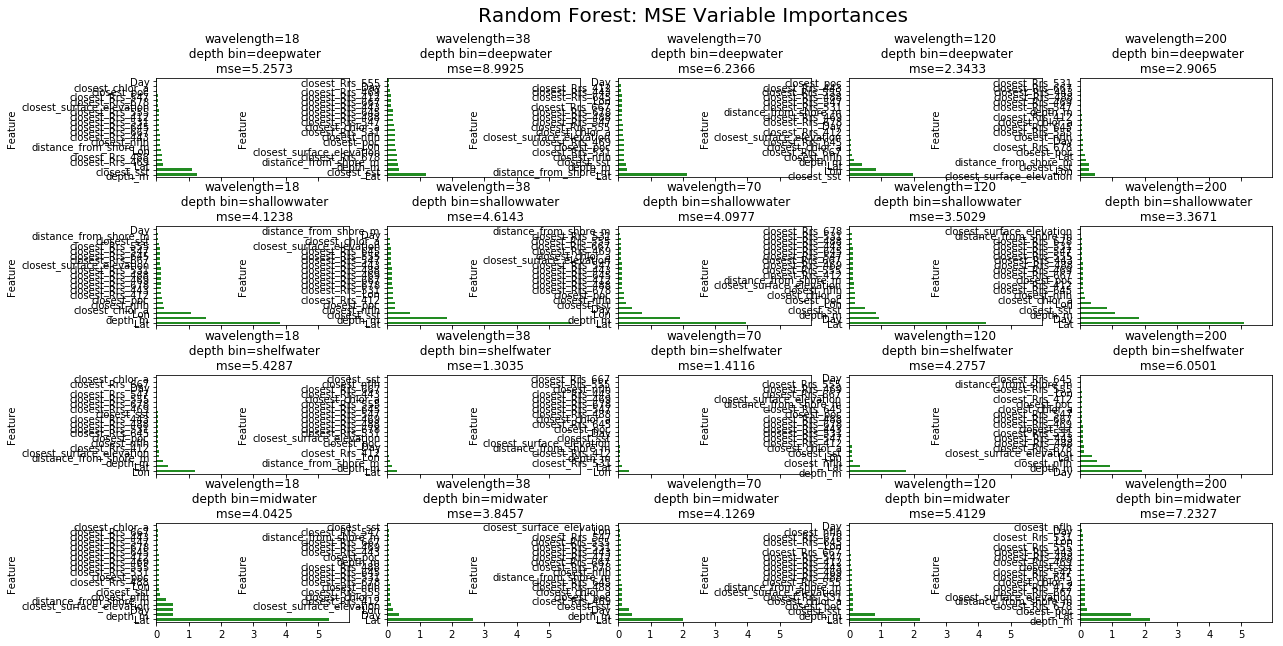

In [33]:
## Random Forest variable importances

# MSE
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

color = ['forestgreen']#,'darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']

rf_mse_list = []
rf_mse_dict = {}
rf_mse_list2 = []
imps = []
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe  # data all on common scale
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)
        
        ## do the same for mse
        rf_imp_mse = importances(rf, x_test, y_test, metric=mse)
        
        title = "\n wavelength={0}\n depth bin={1}\n mse={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(rf,x_test, y_test))
        rf_imp_mse.Importance = np.abs(rf_imp_mse.Importance.values)
        imps.append(np.abs(rf_imp_mse.Importance.values))
        
        #plot_importances(rf_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color)
        rf_imp_mse.Importance.nlargest(len(d.columns)).plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
        axes[j, i].set_title(title)
        
        # add model to lst of dfs...concatenate later
        #change title of columns in df from 'importance_x' to 'model...'
        rfmse_df = rf_imp_mse.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_list.append(rfmse_df)
        
        #new_df = rf_imp_mse.rename(index=str, columns={'Label':f'{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':mse(rf,x_test, y_test)})  # actual mse values
        rf_mse_list2.append(mse(rf,x_test, y_test))

        
plt.subplots_adjust(hspace=0.5)#,wspace=1.1)
fig.suptitle('Random Forest: MSE Variable Importances \n',fontsize=20)
plt.savefig('2019-06-03_RF-MSE_var_importances.png')
plt.show()


In [37]:
### df rf mse

# df: sort values descending and ascending values for max avg
from functools import reduce

# make row identifier "column" a real column
for i in rf_mse_list:
    i.reset_index(inplace=True)

# sort by mean model importance to determine sort order for plots
#print(df_list[0], (df_list[0]).shape)
df_rf_mse = reduce(lambda x, y: pd.merge(x, y, on = 'Feature'), rf_mse_list)
reduce(lambda x, y: pd.merge(x, y, on = 'Feature'), rf_mse_list)


,Feature,Importance_18_deepwater,Importance_18_shallowwater,Importance_18_shelfwater,Importance_18_midwater,Importance_38_deepwater,Importance_38_shallowwater,Importance_38_shelfwater,Importance_38_midwater,Importance_70_deepwater,...,Importance_70_shelfwater,Importance_70_midwater,Importance_120_deepwater,Importance_120_shallowwater,Importance_120_shelfwater,Importance_120_midwater,Importance_200_deepwater,Importance_200_shallowwater,Importance_200_shelfwater,Importance_200_midwater
0,closest_Rrs_469,0.172445,0.137129,0.031743,0.065953,0.097029,0.136836,0.006205,0.055663,0.165927,...,0.005153,0.116501,0.028851,0.123586,0.004074,0.075359,0.024907,0.087207,0.076036,0.116082
1,closest_Rrs_488,0.161048,0.134178,0.042199,0.081279,0.174946,0.135494,0.006301,0.060142,0.130175,...,0.007164,0.102264,0.003134,0.097948,0.019612,0.081559,0.020045,0.086747,0.100705,0.113447
2,distance_from_shore_m,0.114885,0.049242,0.065238,0.296631,0.301645,0.019755,0.079140,0.051581,0.273466,...,0.056184,0.091618,0.019418,0.134522,0.015368,0.092525,0.180353,0.037033,0.014810,0.165990
3,closest_nflh,0.101935,0.209140,0.059462,0.104077,0.225456,0.238842,0.003753,0.069706,0.177818,...,0.003229,0.090319,0.080889,0.162116,0.107641,0.025944,0.071837,0.117349,0.519439,0.026235
4,closest_Rrs_443,0.096018,0.148901,0.041133,0.050740,0.125523,0.122952,0.004852,0.058571,0.084811,...,0.005040,0.075424,0.002589,0.100114,0.022552,0.070319,0.018291,0.076197,0.098401,0.109535
5,closest_Rrs_667,0.091402,0.119795,0.018927,0.041102,0.114120,0.145386,0.004751,0.052342,0.121825,...,0.001817,0.083329,0.063994,0.113277,0.009058,0.031858,0.014148,0.093203,0.064391,0.159586
6,closest_Rrs_645,0.085234,0.109622,0.050214,0.057888,0.170047,0.106085,0.006107,0.063130,0.110218,...,0.008192,0.099773,0.044814,0.105132,0.016613,0.028109,0.058579,0.099859,0.004785,0.125516
7,closest_Rrs_531,0.078903,0.130250,0.047452,0.073366,0.222418,0.180903,0.006688,0.063245,0.177316,...,0.061221,0.073155,0.010929,0.090538,0.023187,0.104982,0.002227,0.062687,0.087266,0.082089
8,closest_Rrs_412,0.077585,0.149073,0.062066,0.063609,0.108951,0.188275,0.011626,0.084239,0.084568,...,0.056866,0.075796,0.038830,0.128834,0.027313,0.054417,0.057718,0.099552,0.054448,0.158497
9,closest_surface_elevation,0.062157,0.121007,0.064879,0.497532,0.267804,0.089063,0.008178,0.115752,0.151236,...,0.037131,0.013095,0.039504,0.154393,0.014267,0.103346,0.449897,0.023977,0.121851,0.165962


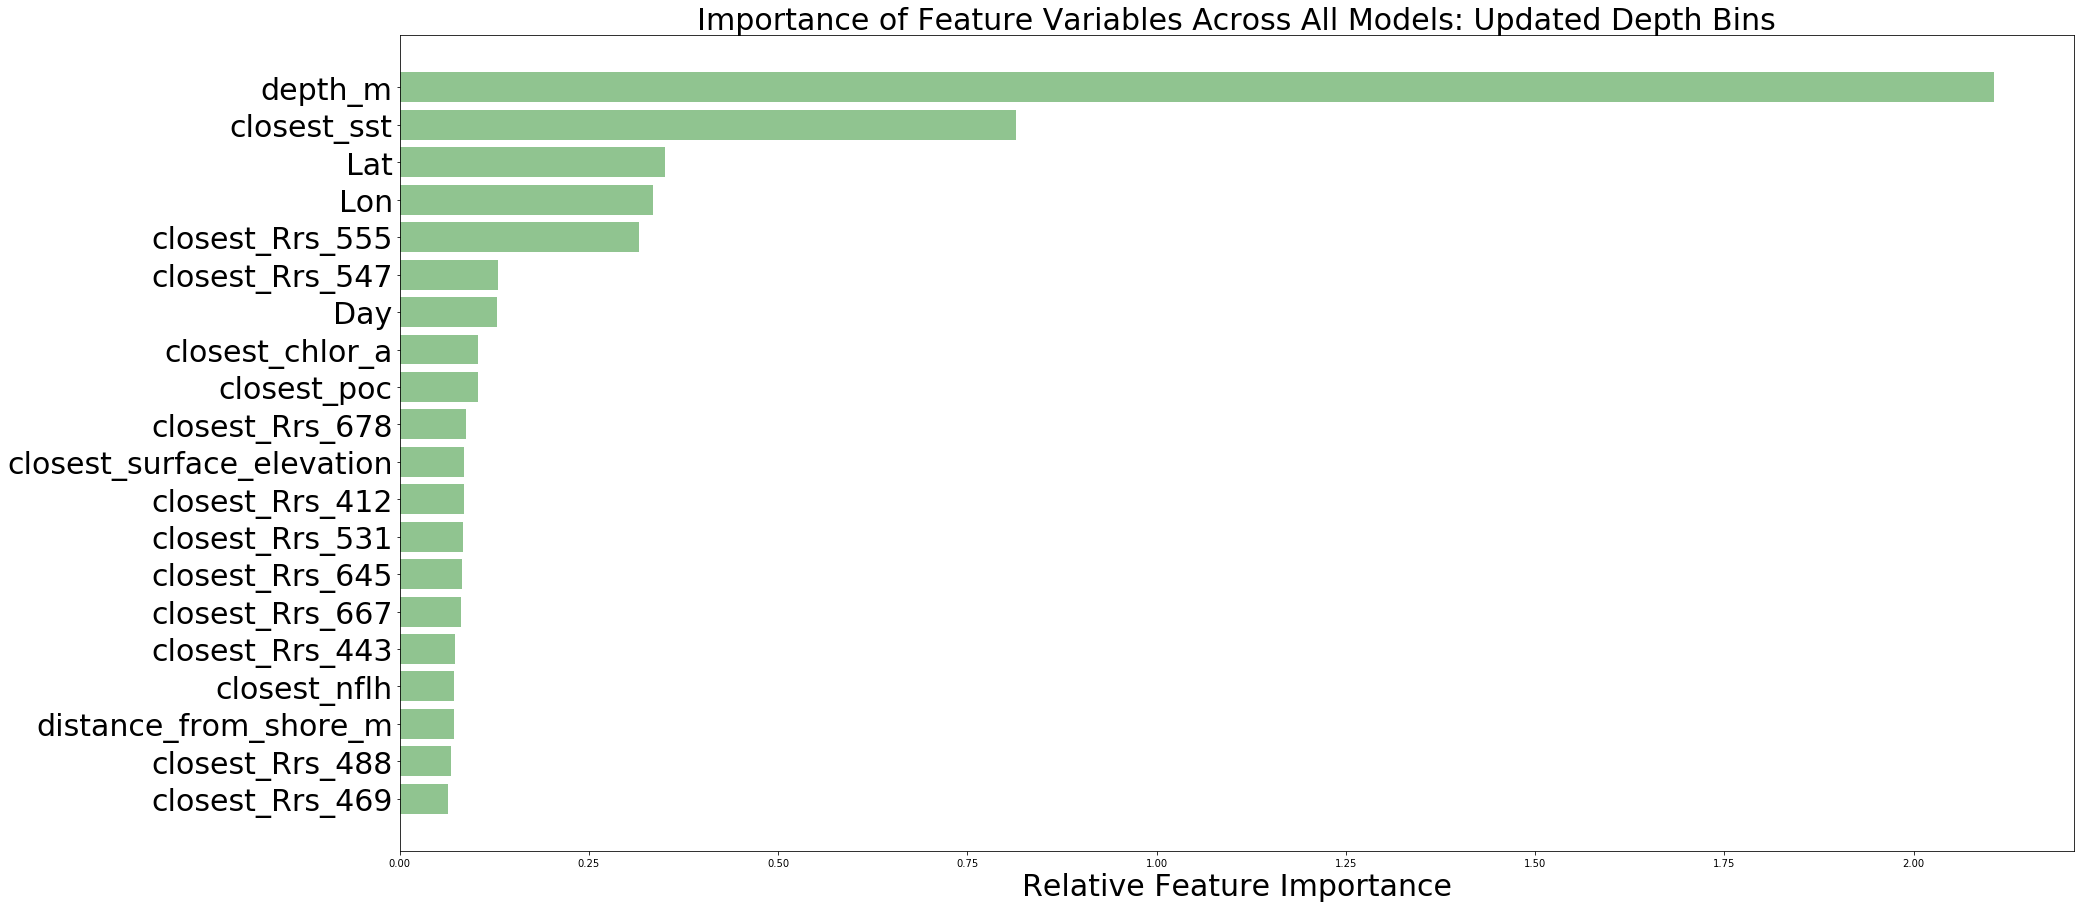

In [54]:
# get the average relative feature importances for all models

col_rfmse = df_rf_mse.columns[1:]  # gets just the importances columns, not index or feature name columns
df_rf_mse.columns
col_list = list(df_rf_mse)

def remove_vals(the_list, val):
    return [value for value in the_list if value != val]

x = remove_vals(col_list, 'index_y')
y = remove_vals(x, 'index_x')
#print(y[1:])

#df_rf_mse.drop(columns=['imp_sums','test'])
#z = remove_vals(y, 'index')
#b = remove_vals(z, 'imp_sums')
#c = remove_vals(b, 'test')

#print(df_rf_mse.loc[[0]])
#print(df_rf_mse[y].loc[[0]])
#df_rf_mse[c]

feature_labels = df_rf_mse['Feature']
feature_sum = df_rf_mse.sum(axis=1) / len(feature_labels)  # average of values
#print(feature_sum)
feature_sum = feature_sum.sort_values()

# plot ranking of var importances across all models while using rf
y_pos = np.arange(len(feature_labels))
fig = plt.figure(figsize=(30,15))
plt.barh(y_pos, feature_sum, align='center', alpha=0.5,color='forestgreen')
plt.yticks(y_pos, feature_labels,fontsize=30)
plt.xlabel('Relative Feature Importance',fontsize=30)
plt.title('Importance of Feature Variables Across All Models: Updated Depth Bins',fontsize=30)
plt.savefig('2019-06-03_importance_feature_variables_all_models.png')
plt.show()

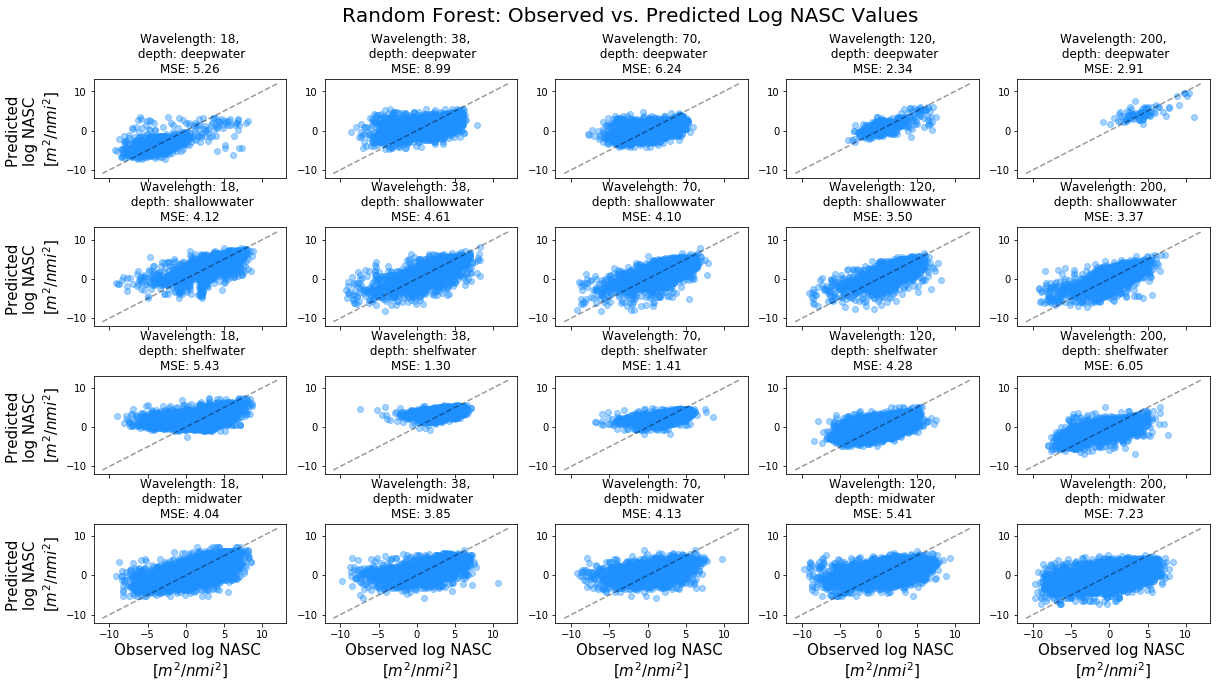

In [34]:
## Random Forest NASC Values

# MSE 
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)
        
        y_test_hat = rf.predict(x_test)
        y_train_hat = rf.predict(x_train)
        
        axes[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
        #axes[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
        axes[j, i].plot(yrange, yrange, '--',c='k',alpha = 0.4)
        axes[j, i].set_title('Wavelength: ' + str(wavelength) + ',\n depth: ' + str(depth_bin) + 
                           '\n' + 'MSE: ' + "%.2f" % mse(rf,x_test, y_test))
        
        # add axis labels on the edge plots
        if wavelength == wavelengths[0]:
            axes[j, i].set_ylabel('Predicted \nlog NASC \n[$m^2 /nmi^2$]', fontsize = 15)
        if depth_bin == depth_bins[-1]:
            axes[j, i].set_xlabel('Observed log NASC \n[$m^2 /nmi^2$]', fontsize = 15)
     
plt.subplots_adjust(hspace=0.5,wspace=0.2)
fig.suptitle('Random Forest: Observed vs. Predicted Log NASC Values \n',fontsize=20)
plt.savefig('2019-06-03_RF-MSE_obsVpredicted_test.png')
plt.show()

## Compare Years: 2012, 2013, 2015 ... in progress

In [62]:
# combine years into one file to predict one year

common_path = '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/'
files = ['2019-06-03_2012_nasc_sonar.csv','2019-06-03_2013_nasc_sonar.csv','2019-06-03_2015_nasc_sonar.csv']
all_filenames = []
for i,k in enumerate(files):
    ### cycle through each year of data, set up dataframe of data ###
    path = common_path+files[i]
    all_filenames.append(path)
print(all_filenames)

combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

combined_path = "/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/combined_csv.csv"
combined_d = pd.read_csv(combined_path)#, nrows=100000) #had trouble getting permissions to read csv while trying to open in excel
print(combined_d.columns)


['/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-06-03_2012_nasc_sonar.csv', '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-06-03_2013_nasc_sonar.csv', '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-06-03_2015_nasc_sonar.csv']
Index(['NASC', 'Timestamp', 'date', 'time', 'Sv_mean', 'Sv_min', 'Sv_max',
       'Thickness_mean', 'Range_mean', 'Dist',
       ...
       'closest_Rrs_469', 'closest_Rrs_488', 'closest_Rrs_531',
       'closest_Rrs_547', 'closest_Rrs_555', 'closest_Rrs_645',
       'closest_Rrs_667', 'closest_Rrs_678', 'closest_sst',
       'closest_surface_elevation'],
      dtype='object', length=260)


In [63]:
# RF MSE with combined file

d = pd.read_csv(combined_path)#, nrows=100000) #had trouble getting permissions to read csv while trying to open in excel
print(d.columns)

d = d.query('NASC > 0')  # filter out zero-value NASC
d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
d = d.assign(depth_m = d.depth_m.astype(np.float64))
d = d.query('log_nasc < 17.5')

feats = [
    'Lon', 
    'Lat',
    'distance_from_shore_m',
    'depth_m',
    'log_nasc', 
    'wavelength', 
    'depth_bin',
    'Day'
]
filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
d = d[filter_col]
d = d.dropna()

z = d[['Lat','Lon','closest_sst','closest_chlor_a','distance_from_shore_m','depth_m',\
        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
        'closest_Rrs_667','closest_Rrs_678','Day']]

wavelengths = d.wavelength.unique()
wavelengths.sort()
depth_bins = d.depth_bin.unique()

print(wavelengths.shape)
print("wavelengths: ",wavelengths) # wavelengths = d.wavelength.unique()
print("depth bins: ",depth_bins)
print("file shape: ",d.shape)
#print("file shape with no NAN values: ",(d.dropna()).shape,'\n')
#print(d.columns)
print(d.head())

Index(['NASC', 'Timestamp', 'date', 'time', 'Sv_mean', 'Sv_min', 'Sv_max',
       'Thickness_mean', 'Range_mean', 'Dist',
       ...
       'closest_Rrs_469', 'closest_Rrs_488', 'closest_Rrs_531',
       'closest_Rrs_547', 'closest_Rrs_555', 'closest_Rrs_645',
       'closest_Rrs_667', 'closest_Rrs_678', 'closest_sst',
       'closest_surface_elevation'],
      dtype='object', length=260)
(5,)
wavelengths:  [ 18  38  70 120 200]
depth bins:  ['shallowwater' 'shelfwater' 'midwater' 'deepwater']
file shape:  (1499120, 23)
   Day  wavelength     depth_bin  distance_from_shore_m  depth_m         Lon  \
3    2         120  shallowwater           11946.725068    -59.0 -124.213335   
4    3         120  shallowwater           12336.592809    -62.0 -124.228371   
5    3         120  shallowwater           12658.362128    -68.0 -124.242509   
6    3         120  shallowwater           12959.387014    -73.0 -124.256423   
7    3         120  shallowwater           13234.362843    -75.0 -124.2699

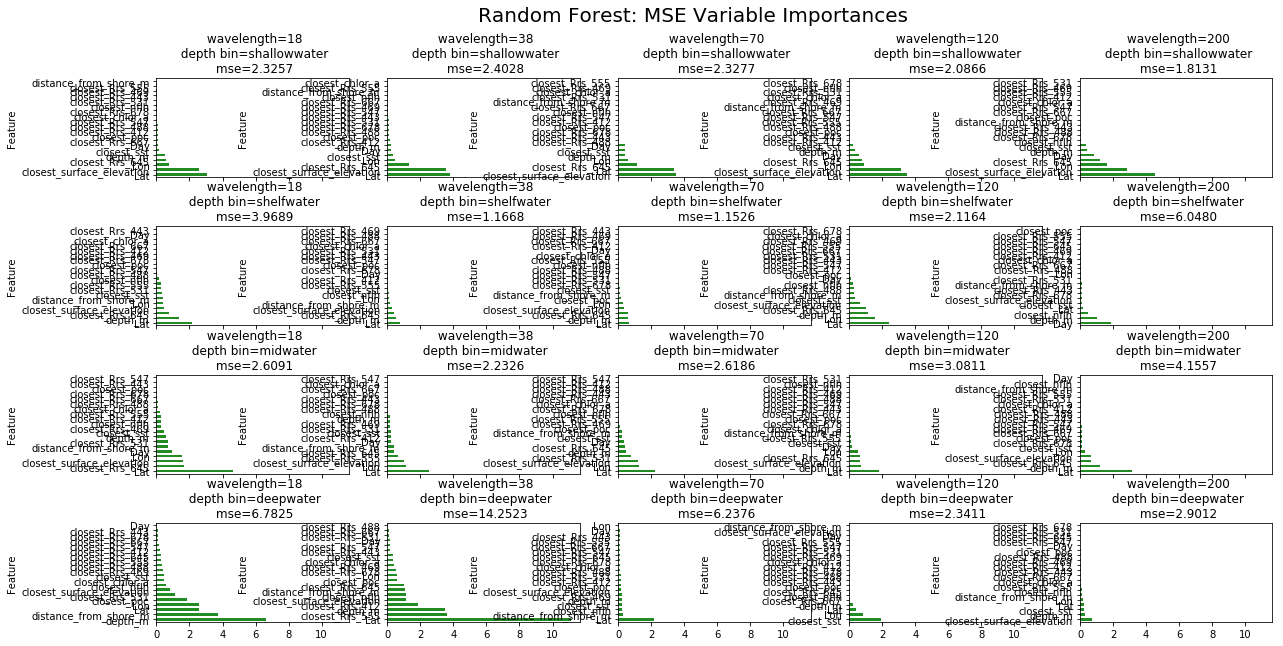

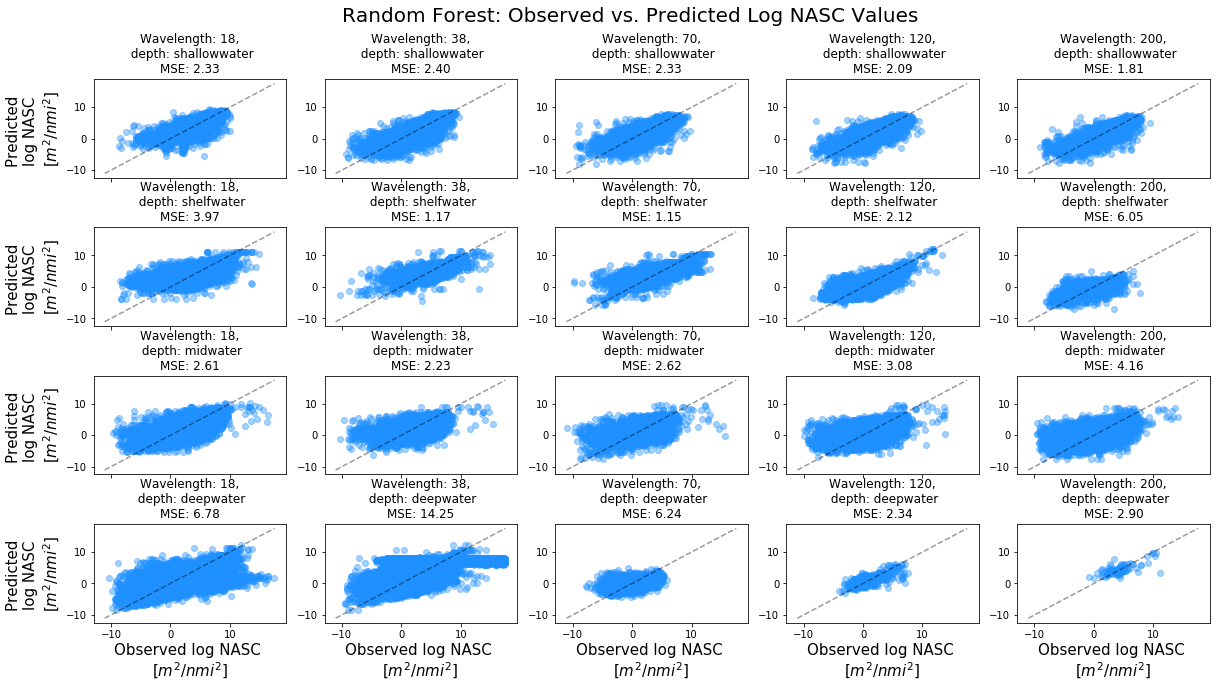

In [64]:
# MSE
# this one combines all three years and predicts log nasc with random selection
# next one splits into 2012,2013 and test 2015...in progress

fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

color = ['forestgreen']#,'darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']

rf_mse_list = []
rf_mse_dict = {}
rf_mse_list2 = []
imps = []
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe  # data all on common scale
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)
        
        ## do the same for mse
        rf_imp_mse = importances(rf, x_test, y_test, metric=mse)
        
        title = "\n wavelength={0}\n depth bin={1}\n mse={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(rf,x_test, y_test))
        rf_imp_mse.Importance = np.abs(rf_imp_mse.Importance.values)
        imps.append(np.abs(rf_imp_mse.Importance.values))
        
        #plot_importances(rf_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color)
        rf_imp_mse.Importance.nlargest(len(d.columns)).plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
        axes[j, i].set_title(title)
        
        # add model to lst of dfs...concatenate later
        #change title of columns in df from 'importance_x' to 'model...'
        rfmse_df = rf_imp_mse.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_list.append(rfmse_df)
        
        #new_df = rf_imp_mse.rename(index=str, columns={'Label':f'{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':mse(rf,x_test, y_test)})  # actual mse values
        rf_mse_list2.append(mse(rf,x_test, y_test))

        
plt.subplots_adjust(hspace=0.5)#,wspace=1.1)
fig.suptitle('Random Forest: MSE Variable Importances \n',fontsize=20)
plt.savefig('combined_csv_RF-MSE_var_importances.png')
plt.show()

#################################################################################################################
# MSE scatter plot 
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)
        
        y_test_hat = rf.predict(x_test)
        y_train_hat = rf.predict(x_train)
        
        axes[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
        #axes[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
        axes[j, i].plot(yrange, yrange, '--',c='k',alpha = 0.4)
        axes[j, i].set_title('Wavelength: ' + str(wavelength) + ',\n depth: ' + str(depth_bin) + 
                           '\n' + 'MSE: ' + "%.2f" % mse(rf,x_test, y_test))
        
        # add axis labels on the edge plots
        if wavelength == wavelengths[0]:
            axes[j, i].set_ylabel('Predicted \nlog NASC \n[$m^2 /nmi^2$]', fontsize = 15)
        if depth_bin == depth_bins[-1]:
            axes[j, i].set_xlabel('Observed log NASC \n[$m^2 /nmi^2$]', fontsize = 15)
     
plt.subplots_adjust(hspace=0.5,wspace=0.2)
fig.suptitle('Random Forest: Observed vs. Predicted Log NASC Values \n',fontsize=20)
plt.savefig('combined_csv_RF-MSE_obsVpredicted_test.png')
plt.show()

In [79]:
# making a function to run through RF and produce plots, takes in new column names to drop

def rf_sonarproject(path,drop_columns):
    '''
    *Runs Random Forest Regressor to predict log NASC values from input csv. 
    *Produces 2 plots. First plot shows relative importance of input variables. Second plot shows observed vs. \
        predicted log NASC Values. 
    *Inputs:
        - path: path of csv file for data
        - drop_columns: list of str column names to drop when running the RF model (used for testing independent \
        outputs from sonar, MODIS, or other data)
        - Options for 'drop_columns' input var:
            > Only MODIS Satellite Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m',\
                        'distance_from_shore_m','Day']
            > Only Sonar Data: drop_columns =['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']
            > Only Non-MODIS or NON-Sonar Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','depth_m',\
                        'distance_from_shore_m']
            > All Non-Satellite Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']
        *** Order of elements in drop_columns list does matter for plot naming and image saving ***
    '''
    d = pd.read_csv(path)#, nrows=100000)
    d = d.query('NASC > 0')  # filter out zero-value NASC
    d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
    d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
    d = d.assign(depth_m = d.depth_m.astype(np.float64))
    d = d.query('log_nasc < 17.5')

    feats = [
        'Lon', 
        'Lat',
        'distance_from_shore_m',
        'depth_m',
        'log_nasc', 
        'wavelength', 
        'depth_bin',
        'Day'
    ]
    filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
    d = d[filter_col]
    d = d.dropna()
    wavelengths = d.wavelength.unique()
    wavelengths.sort()
    depth_bins = d.depth_bin.unique()

    # plot 1: Var Importance
    fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
    yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

    color = ['forestgreen']#,'darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']

    rf_mse_list = []
    rf_mse_dict = {}
    rf_mse_list2 = []
    imps = []
    for i, wavelength in enumerate(wavelengths):
        for j, depth_bin in enumerate(depth_bins):

            subd = d.query('wavelength == ' + str(wavelengths[i]))
            subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
            x = subd.drop(drop_columns, axis=1)
            x[:] = preprocessing.scale(x) # [:] retains dataframe  # data all on common scale
            y = subd.log_nasc
            x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)

            ## fit a RF to the same data
            rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
            rf.fit(x_train, y_train)

            ## do the same for mse
            rf_imp_mse = importances(rf, x_test, y_test, metric=mse)

            title = "\n wavelength={0}\n depth bin={1}\n mse={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(rf,x_test, y_test))
            rf_imp_mse.Importance = np.abs(rf_imp_mse.Importance.values)
            imps.append(np.abs(rf_imp_mse.Importance.values))

            #plot_importances(rf_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color)
            rf_imp_mse.Importance.nlargest(len(d.columns)).plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
            axes[j, i].set_title(title)

            # add model to lst of dfs...concatenate later
            #change title of columns in df from 'importance_x' to 'model...'
            rfmse_df = rf_imp_mse.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
            rf_mse_list.append(rfmse_df)

            #new_df = rf_imp_mse.rename(index=str, columns={'Label':f'{wavelengths[i]}_{depth_bins[j]}'})
            rf_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':mse(rf,x_test, y_test)})  # actual mse values
            rf_mse_list2.append(mse(rf,x_test, y_test))


    plt.subplots_adjust(hspace=0.5)#,wspace=1.1)
    # MODIS data only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m','distance_from_shore_m','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - MODIS Satellite Data Only \n',fontsize=20)
        plt.savefig('MODISsatOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only Sonar + depth_m + distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only Sonar + depth_m + distance_from_shore_m \n',\
                     fontsize=20)
        plt.savefig('SatdataExcluded_RF-MSE_var_importances.png')
        plt.show()
    # Sonar Data Only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']:
        fig.suptitle('Random Forest: MSE Variable Importances - Sonar Data Only \n',fontsize=20)
        plt.savefig('SonarDataOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only depth_m and distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','Lat','Lon','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only depth_m and distance_from_shore_m \n',fontsize=20)
        plt.savefig('onlydepthAnddistfromshore_RF-MSE_var_importances.png')
        plt.show()

    #################################################################################################################
    # Plot 2: Observed vs. Predicted Log NASC
    fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                           sharex=True, figsize=(20, 10))
    yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

    for i, wavelength in enumerate(wavelengths):
        for j, depth_bin in enumerate(depth_bins):

            subd = d.query('wavelength == ' + str(wavelengths[i]))
            subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
            x = subd.drop(drop_columns, axis=1)
            x[:] = preprocessing.scale(x) # [:] retains dataframe
            y = subd.log_nasc
            x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)

            ## fit a RF to the same data
            rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
            rf.fit(x_train, y_train)

            y_test_hat = rf.predict(x_test)
            y_train_hat = rf.predict(x_train)

            axes[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
            #axes[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
            axes[j, i].plot(yrange, yrange, '--',c='k',alpha = 0.4)
            axes[j, i].set_title('Wavelength: ' + str(wavelength) + ',\n depth: ' + str(depth_bin) + 
                               '\n' + 'MSE: ' + "%.2f" % mse(rf,x_test, y_test))

            # add axis labels on the edge plots
            if wavelength == wavelengths[0]:
                axes[j, i].set_ylabel('Predicted \nlog NASC \n[$m^2 /nmi^2$]', fontsize = 15)
            if depth_bin == depth_bins[-1]:
                axes[j, i].set_xlabel('Observed log NASC \n[$m^2 /nmi^2$]', fontsize = 15)

    plt.subplots_adjust(hspace=0.5,wspace=0.2)
    # MODIS data only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m','distance_from_shore_m','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - MODIS Satellite Data Only \n',fontsize=20)
        plt.savefig('MODISsatOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only Sonar + depth_m + distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only Sonar + depth_m + distance_from_shore_m \n',\
                     fontsize=20)
        plt.savefig('SatdataExcluded_RF-MSE_var_importances.png')
        plt.show()
    # Sonar Data Only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']:
        fig.suptitle('Random Forest: MSE Variable Importances - Sonar Data Only \n',fontsize=20)
        plt.savefig('SonarDataOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only depth_m and distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','Lat','Lon','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only depth_m and distance_from_shore_m \n',fontsize=20)
        plt.savefig('onlydepthAnddistfromshore_RF-MSE_var_importances.png')
        plt.show()


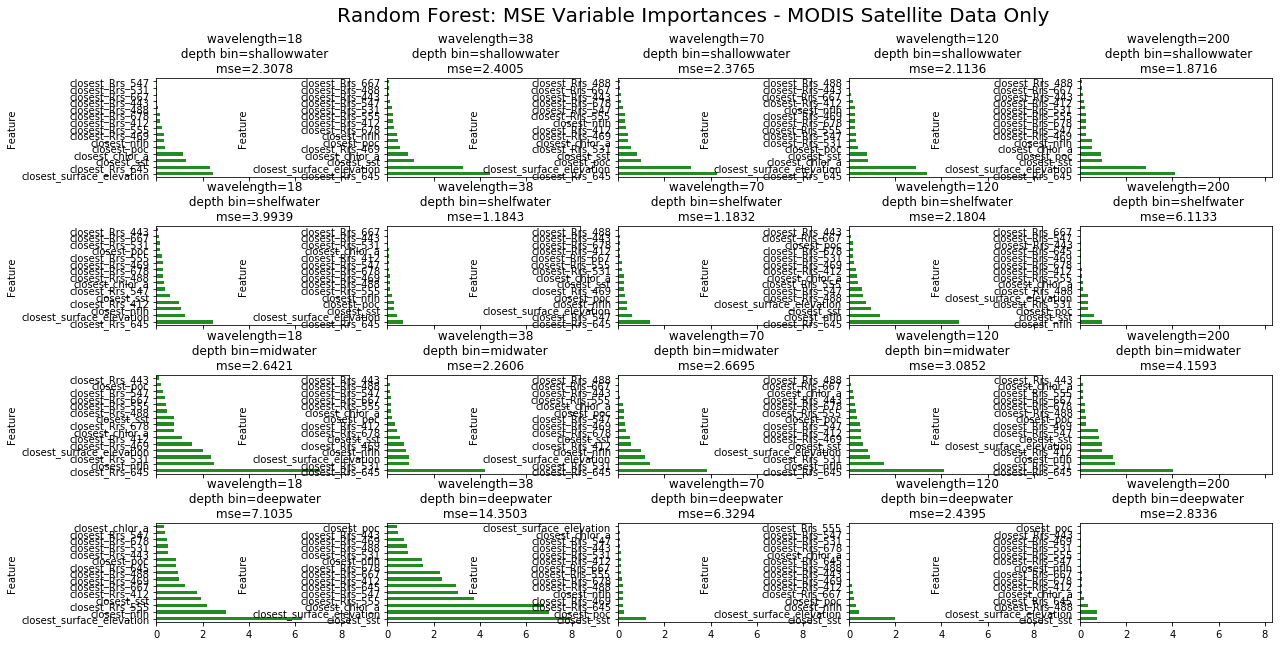

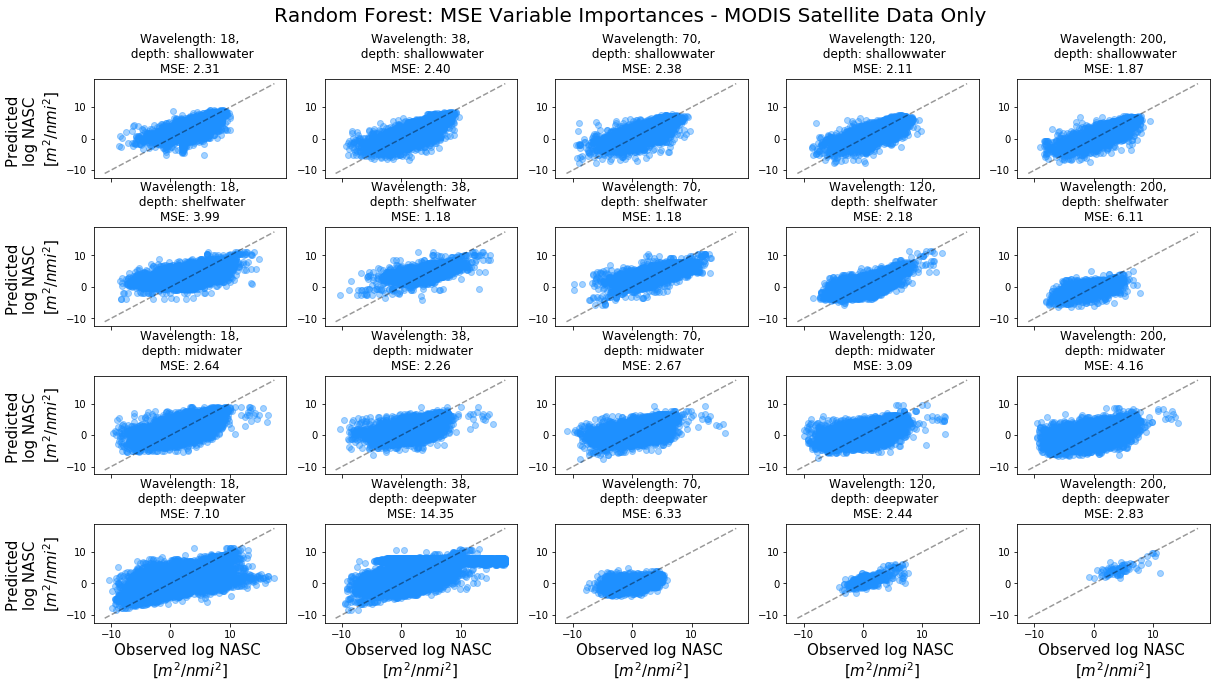

In [80]:
# 1. MODIS Satellite Data Only

drop_columns = ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m','distance_from_shore_m','Day']
rf_sonarproject(combined_path, drop_columns)

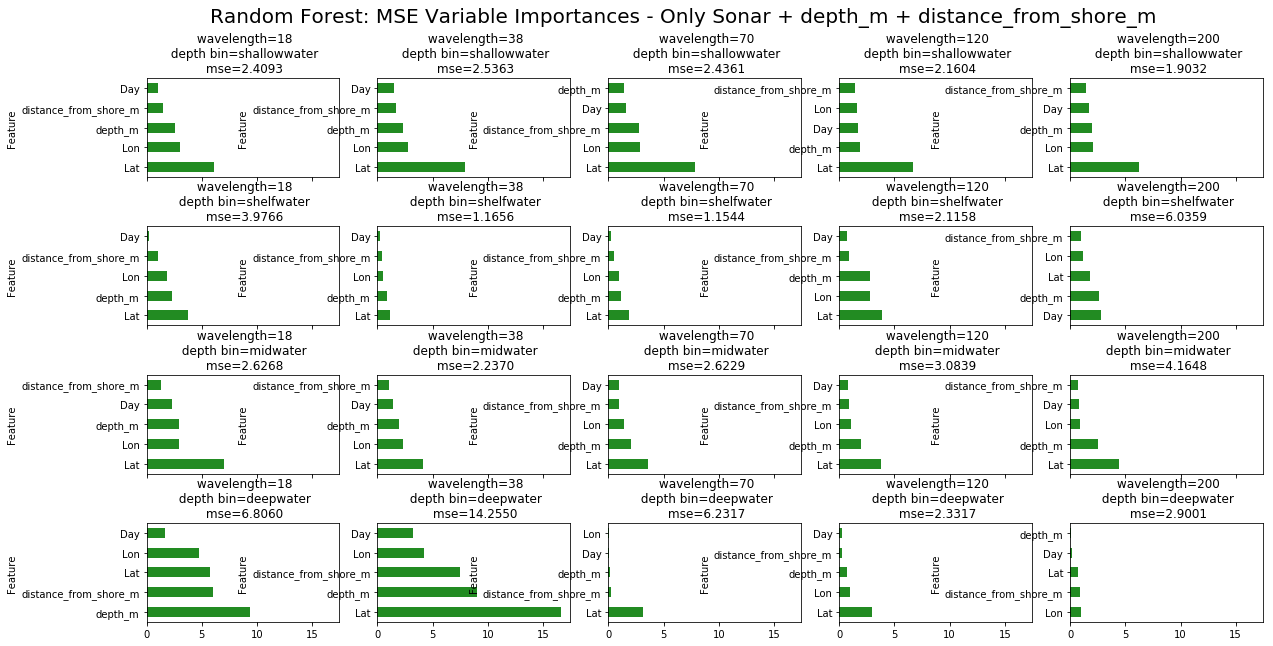

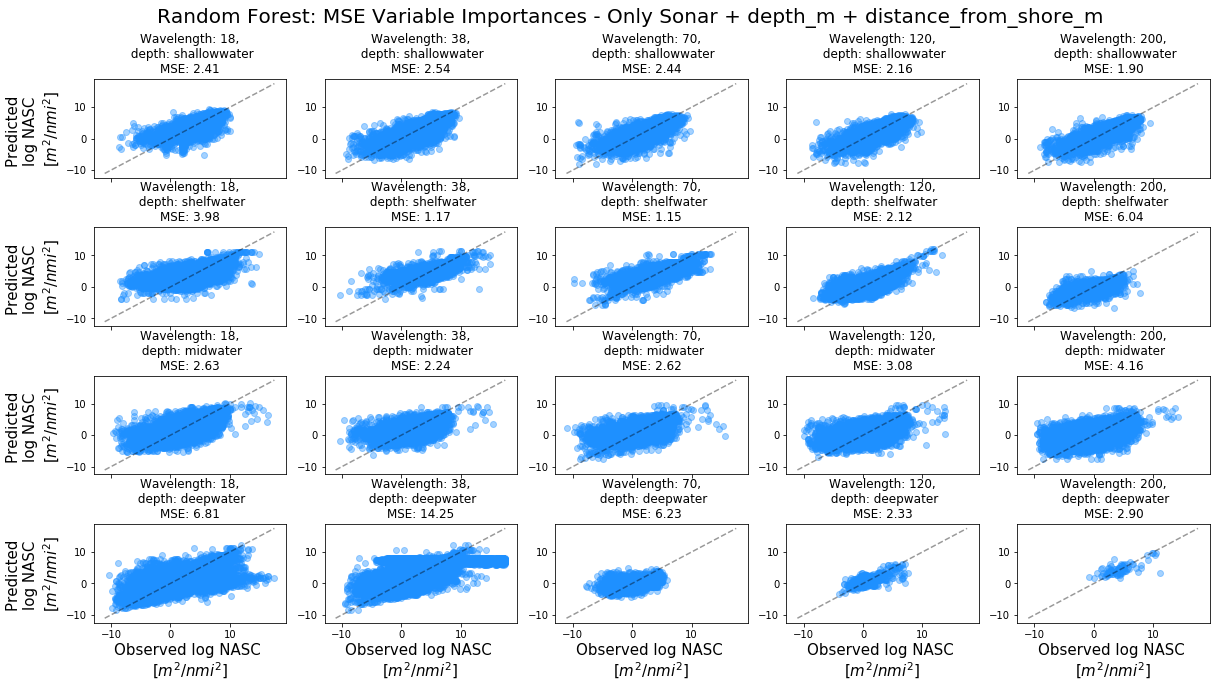

In [86]:
# 2. Only Sonar + depth_m + distance_from_shore_m Data

drop_columns = ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']
rf_sonarproject(combined_path, drop_columns)

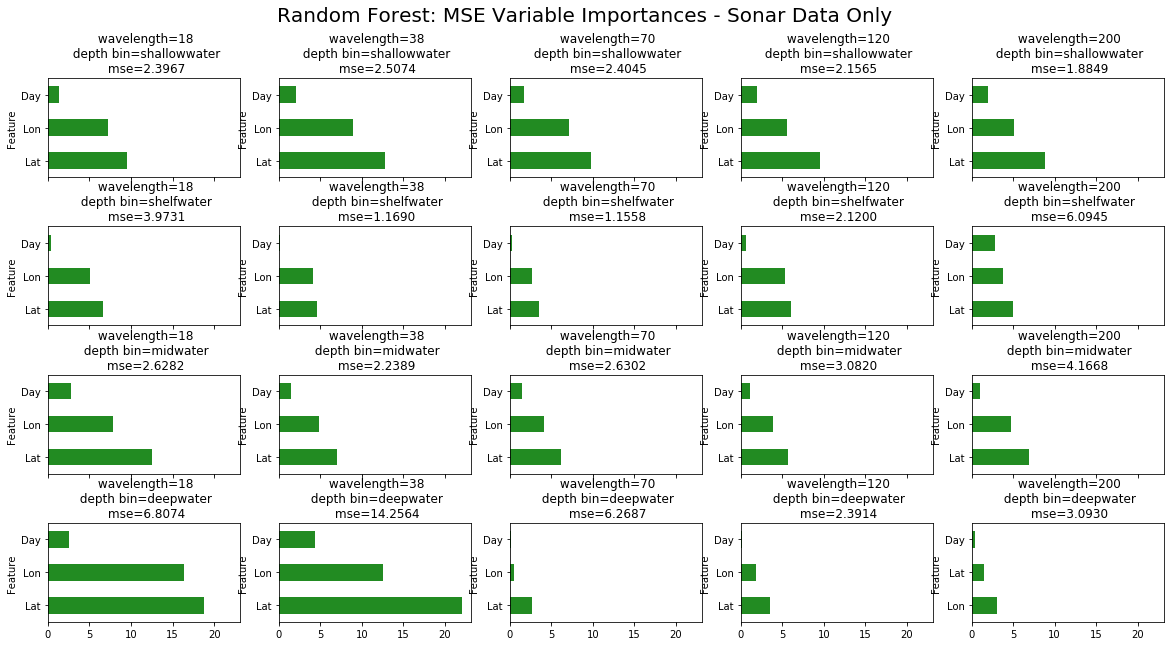

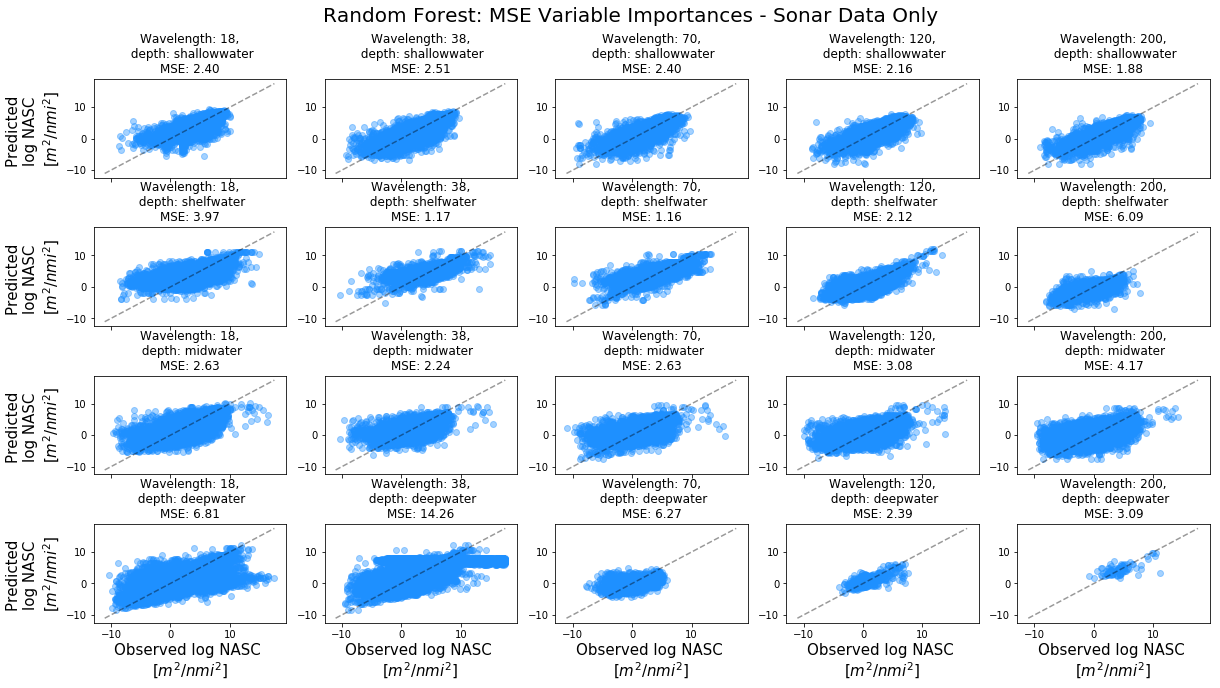

In [87]:
# 3. Sonar Data Only

drop_columns = ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']
rf_sonarproject(combined_path, drop_columns)

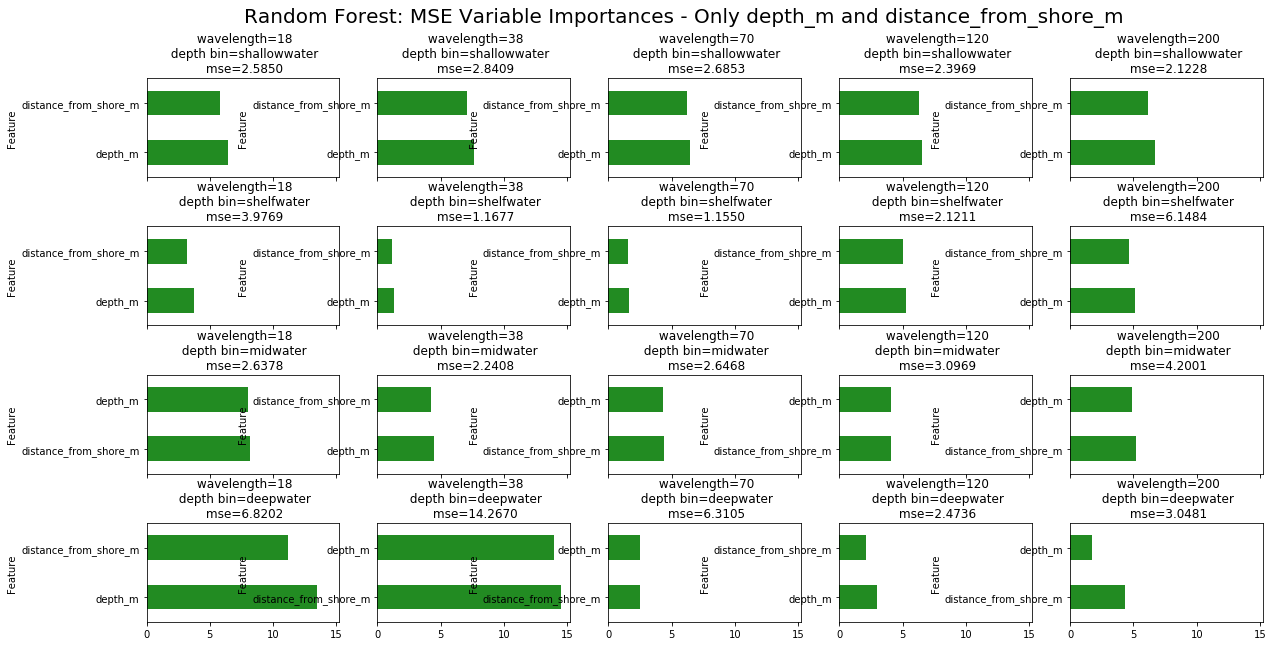

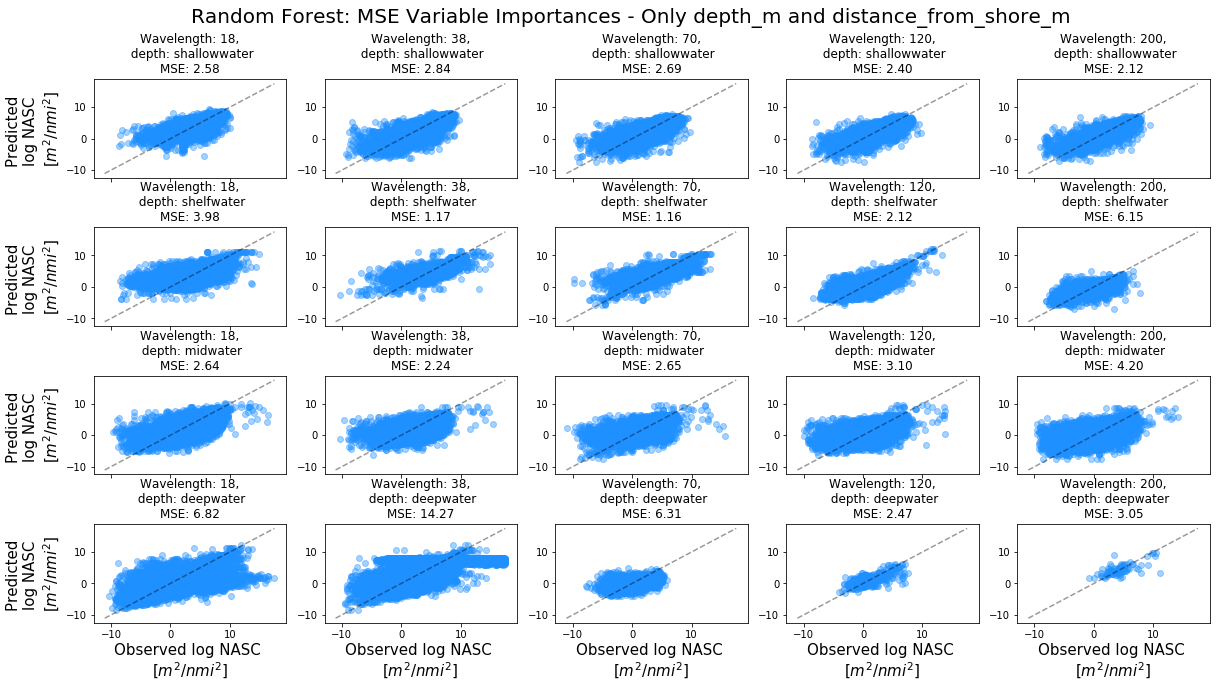

In [88]:
# 4. Only depth_m + distance_from_shore_m Data

drop_columns = ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','Lat','Lon','Day']
rf_sonarproject(combined_path, drop_columns)

# Wreck-It-Ralph Strategy: 
### Divisive Chunks into North and South to Conquer (?) Data Distribution Issues

* method for spatial and temporal distribution for training and testing data - "Wreck it Ralph strategy"
* make a block for North and South to extrapolate the log nasc values for the other (prediction and extrapolation for other regions is the goal here)
> - median lat is 42.3 degrees
> - don't use train_test_split; set each x_train, etc. to csv appropriate rows 
> - don't include lat or lon in sets (rely almost exclusively on sat data but still include depth_m, distance from shore), still include Day from sonar, to predict log NASC values
> - potential problems: over-sampling an area based on time of year, data points are taken over the course of several months, so using North data from May to extrapolate log NASC values for the South in July has temporal issues

* plots: one for when N is held out, one for when the S is held out
* (2 more plots if time) visualize residuals (squared difference between observed and predicted) -> scatter plot (lat on x axis, residuals on y axis)
* powerpoint: include some info from paper Max sent out about why this is a problem (spatial and temporal distribution of data)

In [85]:
# looking at division of North and South chunk dimensions for combined 2012,2013,&2015

print(min(d['Lat']),max(d['Lat']))

mask = d['Lat'] >= 42.3
d1 = d[mask]
d2 = d[~mask]
print (len(d1))
print (len(d2))


32.612736269755835 54.79239693221579
972711
526409


In [ ]:
# function -> update documentation for N and S chunk differentiation

def wreck_it_ralph(path,chunk,drop_columns):
    '''
    *Runs Random Forest Regressor to predict log NASC values from input csv. 
    *Produces 2 plots. First plot shows relative importance of input variables. Second plot shows observed vs. \
        predicted log NASC Values. 
    *Inputs:
        - path: path of csv file for data
        - chunk: str of North or South chunk
        - drop_columns: list of str column names to drop when running the RF model (used for testing independent \
        outputs from sonar, MODIS, or other data)
        
        ** Options for 'chunk' input var:
            > Use North data to predict South Data: chunk = 'North'
            > Use South data to predcit North Data: chunk = 'South'
        
        ** Options for 'drop_columns' input var:
            > All Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon']
            > Only MODIS Satellite Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m',\
                        'distance_from_shore_m','Day']
            > Only Sonar Data: drop_columns =['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']
            > Only Non-MODIS or NON-Sonar Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','depth_m',\
                        'distance_from_shore_m']
            > All Non-Satellite Data: drop_columns = ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']
        *** Order of elements in 'drop_columns' list does matter for plot naming and image saving ***
    '''
    d = pd.read_csv(path)#, nrows=100000)
    d = d.query('NASC > 0')  # filter out zero-value NASC
    d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
    d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
    d = d.assign(depth_m = d.depth_m.astype(np.float64))
    d = d.query('log_nasc < 17.5')

    feats = [
        'Lon', 
        'Lat',
        'distance_from_shore_m',
        'depth_m',
        'log_nasc', 
        'wavelength', 
        'depth_bin',
        'Day'
    ]
    filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
    d = d[filter_col]
    d = d.dropna()
    wavelengths = d.wavelength.unique()
    wavelengths.sort()
    depth_bins = d.depth_bin.unique()

    # plot 1: Var Importance
    fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
    yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

    color = ['forestgreen']#,'darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']

    rf_mse_list = []
    rf_mse_dict = {}
    rf_mse_list2 = []
    imps = []
    for i, wavelength in enumerate(wavelengths):
        for j, depth_bin in enumerate(depth_bins):

            subd = d.query('wavelength == ' + str(wavelengths[i]))
            subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
            x = subd.drop(drop_columns, axis=1)
            x[:] = preprocessing.scale(x) # [:] retains dataframe  # data all on common scale
            y = subd.log_nasc
            #x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)
            
            # run query on csv to differentiate into North and South Chunks (mid Lat = 42.3 degrees)
            # x[all relevant data above 42.3 degrees] = north
            mask = d['Lat'] >= 42.3
            d1 = d[mask]  # North
            d2 = d[~mask] # South
            if chunk == 'North':
                # use North to predict South
                x_train = 
                x_test = 
                y_train = 
                y_test = 
            if chunk == 'South':
                # use South to predict North
                x_train = 
                x_test = 
                y_train = 
                y_test = 

            ## fit a RF to the same data
            rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
            rf.fit(x_train, y_train)

            ## do the same for mse
            rf_imp_mse = importances(rf, x_test, y_test, metric=mse)

            title = "\n wavelength={0}\n depth bin={1}\n mse={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(rf,x_test, y_test))
            rf_imp_mse.Importance = np.abs(rf_imp_mse.Importance.values)
            imps.append(np.abs(rf_imp_mse.Importance.values))

            #plot_importances(rf_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color)
            rf_imp_mse.Importance.nlargest(len(d.columns)).plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
            axes[j, i].set_title(title)

            # add model to lst of dfs...concatenate later
            #change title of columns in df from 'importance_x' to 'model...'
            rfmse_df = rf_imp_mse.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
            rf_mse_list.append(rfmse_df)

            #new_df = rf_imp_mse.rename(index=str, columns={'Label':f'{wavelengths[i]}_{depth_bins[j]}'})
            rf_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':mse(rf,x_test, y_test)})  # actual mse values
            rf_mse_list2.append(mse(rf,x_test, y_test))


    plt.subplots_adjust(hspace=0.5)#,wspace=1.1)
    # MODIS data only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m','distance_from_shore_m','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - MODIS Satellite Data Only \n',fontsize=20)
        plt.savefig('WIR_MODISsatOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only Sonar + depth_m + distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only Sonar + depth_m + distance_from_shore_m \n',\
                     fontsize=20)
        plt.savefig('WIR_SatdataExcluded_RF-MSE_var_importances.png')
        plt.show()
    # Sonar Data Only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']:
        fig.suptitle('Random Forest: MSE Variable Importances - Sonar Data Only \n',fontsize=20)
        plt.savefig('WIR_SonarDataOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only depth_m and distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','Lat','Lon','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only depth_m and distance_from_shore_m \n',fontsize=20)
        plt.savefig('WIR_onlydepthAnddistfromshore_RF-MSE_var_importances.png')
        plt.show()
    else:
        plt.subplots_adjust(hspace=0.5,wspace=0.2)
        fig.suptitle('Random Forest: MSE Variable Importances: Wreck-It-Ralph Strategy \n',fontsize=20)
        plt.savefig('WIR_combined_csv_RF-MSE_var_importances.png')
        plt.show()

    #################################################################################################################
    # Plot 2: Observed vs. Predicted Log NASC
    fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                           sharex=True, figsize=(20, 10))
    yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

    for i, wavelength in enumerate(wavelengths):
        for j, depth_bin in enumerate(depth_bins):

            subd = d.query('wavelength == ' + str(wavelengths[i]))
            subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
            x = subd.drop(drop_columns, axis=1)
            x[:] = preprocessing.scale(x) # [:] retains dataframe
            y = subd.log_nasc
            x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)

            ## fit a RF to the same data
            rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
            rf.fit(x_train, y_train)

            y_test_hat = rf.predict(x_test)
            y_train_hat = rf.predict(x_train)

            axes[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
            #axes[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
            axes[j, i].plot(yrange, yrange, '--',c='k',alpha = 0.4)
            axes[j, i].set_title('Wavelength: ' + str(wavelength) + ',\n depth: ' + str(depth_bin) + 
                               '\n' + 'MSE: ' + "%.2f" % mse(rf,x_test, y_test))

            # add axis labels on the edge plots
            if wavelength == wavelengths[0]:
                axes[j, i].set_ylabel('Predicted \nlog NASC \n[$m^2 /nmi^2$]', fontsize = 15)
            if depth_bin == depth_bins[-1]:
                axes[j, i].set_xlabel('Observed log NASC \n[$m^2 /nmi^2$]', fontsize = 15)

    plt.subplots_adjust(hspace=0.5,wspace=0.2)
    # MODIS data only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','Lat','Lon','depth_m','distance_from_shore_m','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - MODIS Satellite Data Only \n',fontsize=20)
        plt.savefig('MODISsatOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only Sonar + depth_m + distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only Sonar + depth_m + distance_from_shore_m \n',\
                     fontsize=20)
        plt.savefig('SatdataExcluded_RF-MSE_var_importances.png')
        plt.show()
    # Sonar Data Only:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','depth_m',\
                        'distance_from_shore_m']:
        fig.suptitle('Random Forest: MSE Variable Importances - Sonar Data Only \n',fontsize=20)
        plt.savefig('SonarDataOnly_RF-MSE_var_importances.png')
        plt.show()
    # Only depth_m and distance_from_shore_m:
    if drop_columns == ['log_nasc', 'wavelength', 'depth_bin','closest_sst','closest_chlor_a',\
                        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                        'closest_Rrs_667','closest_Rrs_678','closest_surface_elevation','Lat','Lon','Day']:
        fig.suptitle('Random Forest: MSE Variable Importances - Only depth_m and distance_from_shore_m \n',fontsize=20)
        plt.savefig('onlydepthAnddistfromshore_RF-MSE_var_importances.png')
        plt.show()
    else:
        plt.subplots_adjust(hspace=0.5,wspace=0.2)
        fig.suptitle('Random Forest: Observed vs. Predicted Log NASC Values: Wreck-It-Ralph Strategy \n',fontsize=20)
        plt.savefig('WIR_combined_csv_RF-MSE_obsVpredicted_test.png')
        plt.show()

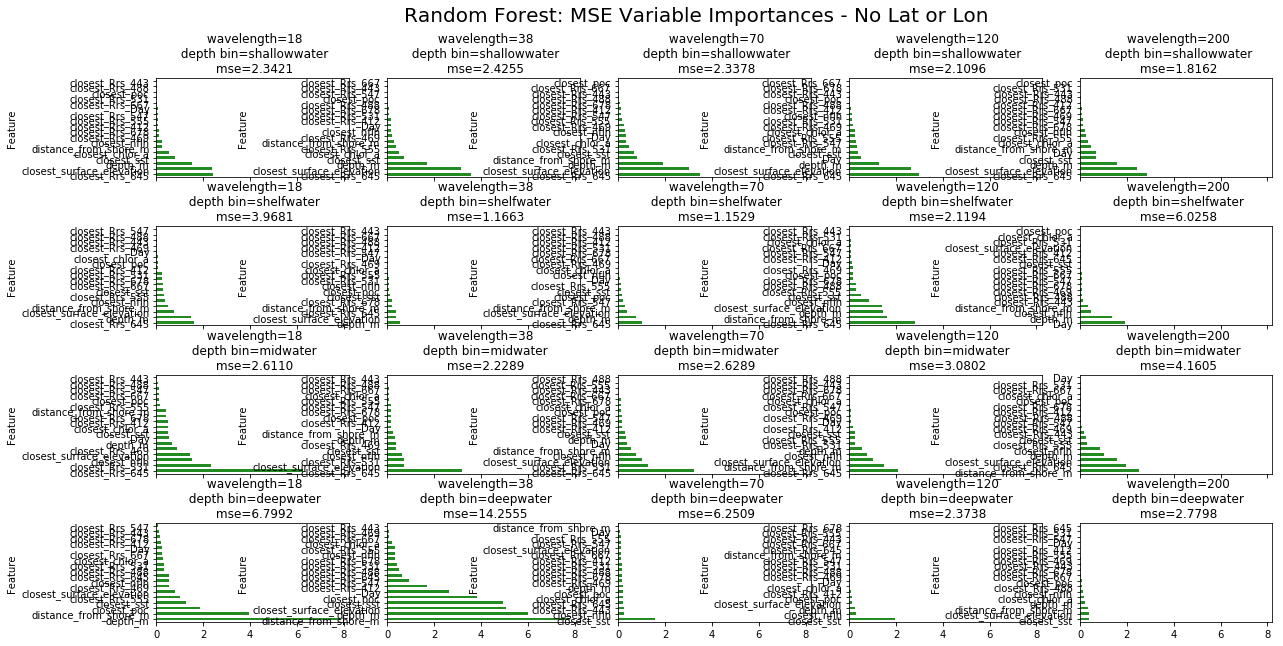

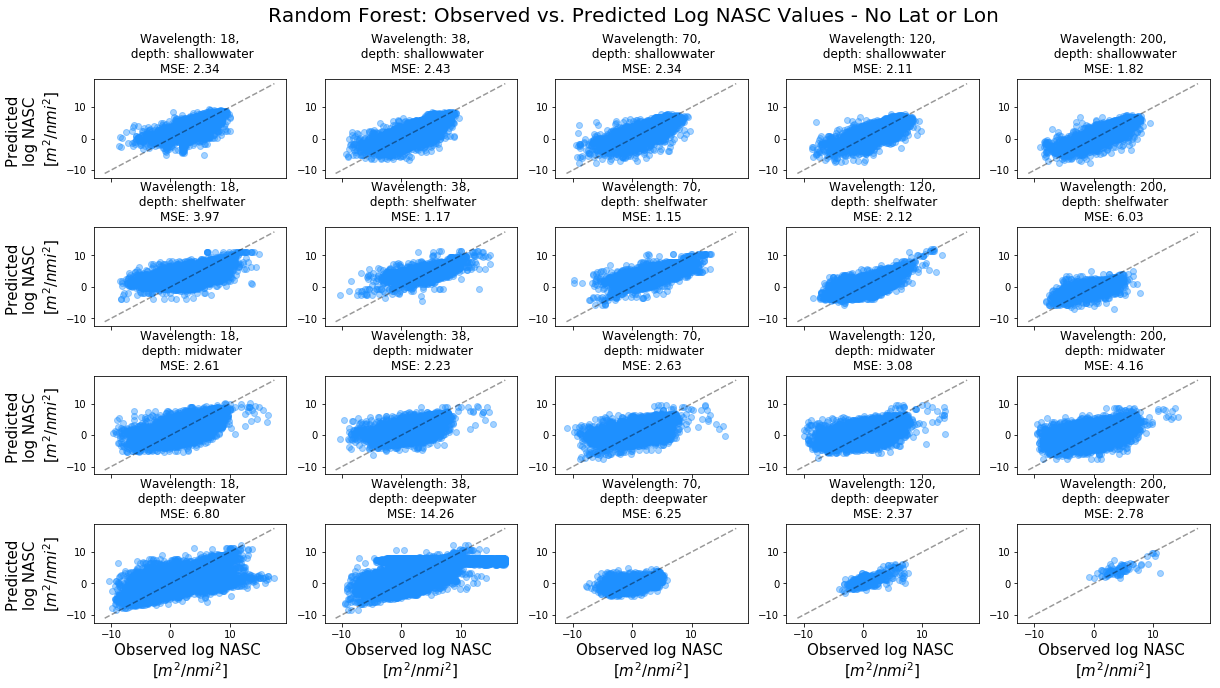

In [69]:
# MSE
# this one combines all three years and predicts log nasc with random selection, also takes out lat and lon
# 
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

color = ['forestgreen']#,'darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']

rf_mse_list = []
rf_mse_dict = {}
rf_mse_list2 = []
imps = []
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin','Lat','Lon'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe  # data all on common scale
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)
        
        ## do the same for mse
        rf_imp_mse = importances(rf, x_test, y_test, metric=mse)
        
        title = "\n wavelength={0}\n depth bin={1}\n mse={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(rf,x_test, y_test))
        rf_imp_mse.Importance = np.abs(rf_imp_mse.Importance.values)
        imps.append(np.abs(rf_imp_mse.Importance.values))
        
        #plot_importances(rf_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color)
        rf_imp_mse.Importance.nlargest(len(d.columns)).plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
        axes[j, i].set_title(title)
        
        # add model to lst of dfs...concatenate later
        #change title of columns in df from 'importance_x' to 'model...'
        rfmse_df = rf_imp_mse.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_list.append(rfmse_df)
        
        #new_df = rf_imp_mse.rename(index=str, columns={'Label':f'{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':mse(rf,x_test, y_test)})  # actual mse values
        rf_mse_list2.append(mse(rf,x_test, y_test))

        
plt.subplots_adjust(hspace=0.5)#,wspace=1.1)
fig.suptitle('Random Forest: MSE Variable Importances - No Lat or Lon\n',fontsize=20)
plt.savefig('nolatlon_RF-MSE_var_importances.png')
plt.show()

#################################################################################################################
# MSE scatter plot 
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin','Lat','Lon'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe
        y = subd.log_nasc
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)
        
        y_test_hat = rf.predict(x_test)
        y_train_hat = rf.predict(x_train)
        
        axes[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
        #axes[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
        axes[j, i].plot(yrange, yrange, '--',c='k',alpha = 0.4)
        axes[j, i].set_title('Wavelength: ' + str(wavelength) + ',\n depth: ' + str(depth_bin) + 
                           '\n' + 'MSE: ' + "%.2f" % mse(rf,x_test, y_test))
        
        # add axis labels on the edge plots
        if wavelength == wavelengths[0]:
            axes[j, i].set_ylabel('Predicted \nlog NASC \n[$m^2 /nmi^2$]', fontsize = 15)
        if depth_bin == depth_bins[-1]:
            axes[j, i].set_xlabel('Observed log NASC \n[$m^2 /nmi^2$]', fontsize = 15)
     
plt.subplots_adjust(hspace=0.5,wspace=0.2)
fig.suptitle('Random Forest: Observed vs. Predicted Log NASC Values - No Lat or Lon\n',fontsize=20)
plt.savefig('nolatlon_RF-MSE_obsVpredicted_test.png')
plt.show()

In [65]:
# combine years 2012 and 2013 into one file to predict year 2015 ... in progress

common_path = '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/'
files = ['2019-06-03_2012_nasc_sonar.csv','2019-06-03_2013_nasc_sonar.csv']
all_filenames = []
for i,k in enumerate(files):
    ### cycle through each year of data, set up dataframe of data ###
    path = common_path+files[i]
    all_filenames.append(path)
print(all_filenames)

combined_csv_1213 = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_csv_1213.to_csv( "combined_csv_1213.csv", index=False, encoding='utf-8-sig')

combined_path_1213 = "/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/combined_csv.csv"
combined_d_1213 = pd.read_csv(combined_path_1213)#, nrows=100000) #had trouble getting permissions to read csv while trying to open in excel
print(combined_d_1213.columns)

path_15 = '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-06-03_2015_nasc_sonar.csv'



['/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-06-03_2012_nasc_sonar.csv', '/users/kellie/Documents/A College Life ^_^/Undergraduate/CU Boulder/Earthlab - Analytics Hub/sonar_project/2019-06-03_2013_nasc_sonar.csv']
Index(['NASC', 'Timestamp', 'date', 'time', 'Sv_mean', 'Sv_min', 'Sv_max',
       'Thickness_mean', 'Range_mean', 'Dist',
       ...
       'closest_Rrs_469', 'closest_Rrs_488', 'closest_Rrs_531',
       'closest_Rrs_547', 'closest_Rrs_555', 'closest_Rrs_645',
       'closest_Rrs_667', 'closest_Rrs_678', 'closest_sst',
       'closest_surface_elevation'],
      dtype='object', length=260)


In [66]:
# this one splits into 2012,2013 and test 2015
# RF MSE with combined file

# 2012 - 2013
d = pd.read_csv(combined_path_1213)#, nrows=100000) #had trouble getting permissions to read csv while trying to open in excel
print(d.columns)

d = d.query('NASC > 0')  # filter out zero-value NASC
d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
d = d.assign(depth_m = d.depth_m.astype(np.float64))
d = d.query('log_nasc < 17.5')

feats = [
    'Lon', 
    'Lat',
    'distance_from_shore_m',
    'depth_m',
    'log_nasc', 
    'wavelength', 
    'depth_bin',
    'Day'
]
filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
d = d[filter_col]
d = d.dropna()

z = d[['Lat','Lon','closest_sst','closest_chlor_a','distance_from_shore_m','depth_m',\
        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
        'closest_Rrs_667','closest_Rrs_678','Day']]

wavelengths = d.wavelength.unique()
wavelengths.sort()
depth_bins = d.depth_bin.unique()

print(wavelengths.shape)
print("wavelengths: ",wavelengths) # wavelengths = d.wavelength.unique()
print("depth bins: ",depth_bins)
print("file shape: ",d.shape)
#print("file shape with no NAN values: ",(d.dropna()).shape,'\n')
#print(d.columns)
#print(d.head())

# 2015
d_15 = pd.read_csv(path_15)#, nrows=100000) #had trouble getting permissions to read csv while trying to open in excel
print(d_15.columns)

d_15 = d_15.query('NASC > 0')  # filter out zero-value NASC
d_15 = d_15.assign(log_nasc = np.log(d_15.NASC))  # log transform of NASC
d_15 = d_15.assign(closest_chlor_a = np.log(d_15.closest_chlor_a))
d_15 = d_15.assign(depth_m = d_15.depth_m.astype(np.float64))
d_15 = d_15.query('log_nasc < 17.5')

feats_15 = [
    'Lon', 
    'Lat',
    'distance_from_shore_m',
    'depth_m',
    'log_nasc', 
    'wavelength', 
    'depth_bin',
    'Day'
]
filter_col_15 = [col for col in d_15 if (col.startswith('closest') or col in feats_15)]
d_15 = d_15[filter_col_15]
d_15 = d_15.dropna()

z_15 = d_15[['Lat','Lon','closest_sst','closest_chlor_a','distance_from_shore_m','depth_m',\
        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
        'closest_Rrs_667','closest_Rrs_678','Day']]

wavelengths_15 = d_15.wavelength.unique()
wavelengths_15.sort()
depth_bins_15 = d_15.depth_bin.unique()

print(wavelengths_15.shape)
print("wavelengths: ",wavelengths_15) # wavelengths = d.wavelength.unique()
print("depth bins: ",depth_bins_15)
print("file shape: ",d_15.shape)

Index(['NASC', 'Timestamp', 'date', 'time', 'Sv_mean', 'Sv_min', 'Sv_max',
       'Thickness_mean', 'Range_mean', 'Dist',
       ...
       'closest_Rrs_469', 'closest_Rrs_488', 'closest_Rrs_531',
       'closest_Rrs_547', 'closest_Rrs_555', 'closest_Rrs_645',
       'closest_Rrs_667', 'closest_Rrs_678', 'closest_sst',
       'closest_surface_elevation'],
      dtype='object', length=260)
(5,)
wavelengths:  [ 18  38  70 120 200]
depth bins:  ['shallowwater' 'shelfwater' 'midwater' 'deepwater']
file shape:  (1499120, 23)
Index(['NASC', 'Timestamp', 'date', 'time', 'Sv_mean', 'Sv_min', 'Sv_max',
       'Thickness_mean', 'Range_mean', 'Dist',
       ...
       'closest_Rrs_469', 'closest_Rrs_488', 'closest_Rrs_531',
       'closest_Rrs_547', 'closest_Rrs_555', 'closest_Rrs_645',
       'closest_Rrs_667', 'closest_Rrs_678', 'closest_sst',
       'closest_surface_elevation'],
      dtype='object', length=260)
(5,)
wavelengths:  [ 18  38  70 120 200]
depth bins:  ['shallowwater' 'shelfwater'

ValueError: Found input variables with inconsistent numbers of samples: [41420, 19096]

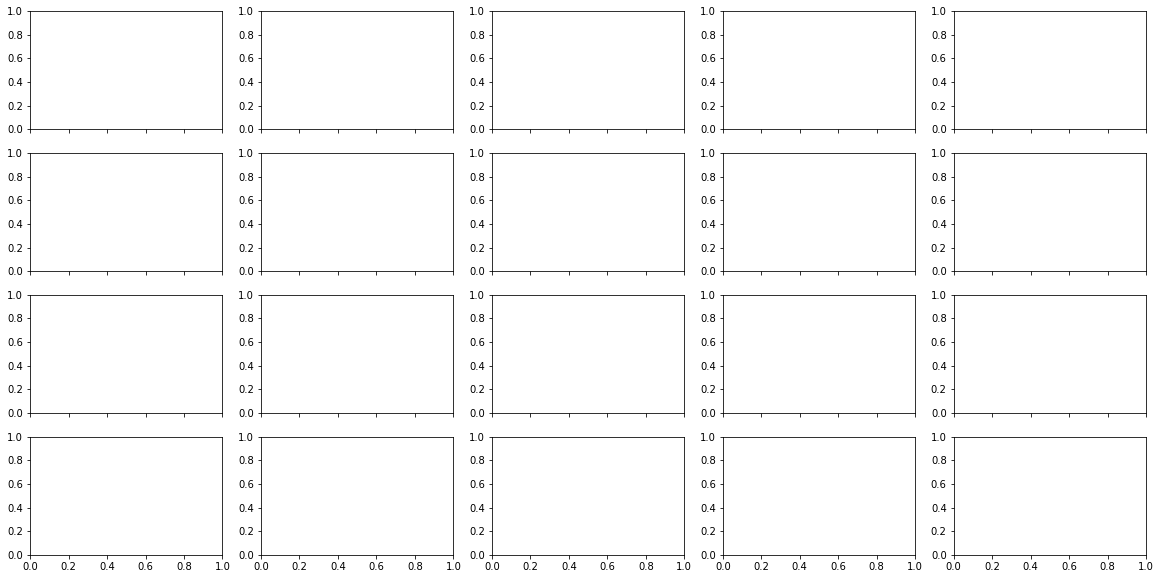

In [68]:
# RF to predcit 2015
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

color = ['forestgreen']#,'darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']

rf_mse_list = []
rf_mse_dict = {}
rf_mse_list2 = []
imps = []
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
        
        subd_15 = d_15.query('wavelength == ' + str(wavelengths_15[i]))
        subd_15 = subd_15.query("depth_bin == '" + str(depth_bins_15[j]) + "'")
        
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe  # data all on common scale
        y = subd.log_nasc
        
        x_15 = subd_15.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x_15[:] = preprocessing.scale(x_15) # [:] retains dataframe  # data all on common scale
        y_15 = subd_15.log_nasc
        
        #x_train, x_test, y_train, y_test = train_test_split(x,y_15, random_state=13)
        x_train = x
        x_test = y
        y_train = x_15
        y_test = y_15
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)
        
        ## do the same for mse
        rf_imp_mse = importances(rf, x_test, y_test, metric=mse)
        
        title = "\n wavelength={0}\n depth bin={1}\n mse={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(rf,x_test, y_test))
        rf_imp_mse.Importance = np.abs(rf_imp_mse.Importance.values)
        imps.append(np.abs(rf_imp_mse.Importance.values))
        
        #plot_importances(rf_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color)
        rf_imp_mse.Importance.nlargest(len(d.columns)).plot(kind='barh', legend=False,subplots = True,ax=axes[j,i],figsize=(20, 10),color=color)
        axes[j, i].set_title(title)
        
        # add model to lst of dfs...concatenate later
        #change title of columns in df from 'importance_x' to 'model...'
        rfmse_df = rf_imp_mse.rename(index=str, columns={'Importance':f'Importance_{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_list.append(rfmse_df)
        
        #new_df = rf_imp_mse.rename(index=str, columns={'Label':f'{wavelengths[i]}_{depth_bins[j]}'})
        rf_mse_dict.update({f'{wavelengths[i]}_{depth_bins[j]}':mse(rf,x_test, y_test)})  # actual mse values
        rf_mse_list2.append(mse(rf,x_test, y_test))

        
plt.subplots_adjust(hspace=0.5)#,wspace=1.1)
fig.suptitle('Random Forest: MSE Variable Importances - Predict 2015\n',fontsize=20)
plt.savefig('predict2015_RF-MSE_var_importances.png')
plt.show()

#################################################################################################################
# MSE scatter plot 
fig, axes = plt.subplots(depth_bins.shape[0], wavelengths.shape[0], 
                       sharex=True, figsize=(20, 10))
yrange = np.linspace(d.log_nasc.min(), d.log_nasc.max(), 100)

for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        subd = d.query('wavelength == ' + str(wavelengths[i]))
        subd = subd.query("depth_bin == '" + str(depth_bins[j]) + "'")
       
        subd_15 = d_15.query('wavelength == ' + str(wavelengths_15[i]))
        subd_15 = subd_15.query("depth_bin == '" + str(depth_bins_15[j]) + "'")
        
        x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x[:] = preprocessing.scale(x) # [:] retains dataframe  # data all on common scale
        y = subd.log_nasc
        
        x_15 = subd_15.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
        x_15[:] = preprocessing.scale(x_15) # [:] retains dataframe  # data all on common scale
        y_15 = subd_15.log_nasc
        
        x_train, x_test, y_train, y_test = train_test_split(x,y_15, random_state=13)
        
        ## fit a RF to the same data
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=13)
        rf.fit(x_train, y_train)
        
        y_test_hat = rf.predict(x_test)
        y_train_hat = rf.predict(x_train)
        
        axes[j, i].scatter(y_test, y_test_hat, alpha=0.4, c='dodgerblue')
        #axes[j, i].scatter(y_train, y_train_hat, alpha = 0.4, c = 'seagreen')
        axes[j, i].plot(yrange, yrange, '--',c='k',alpha = 0.4)
        axes[j, i].set_title('Wavelength: ' + str(wavelength) + ',\n depth: ' + str(depth_bin) + 
                           '\n' + 'MSE: ' + "%.2f" % mse(rf,x_test, y_test))
        
        # add axis labels on the edge plots
        if wavelength == wavelengths[0]:
            axes[j, i].set_ylabel('Predicted \nlog NASC \n[$m^2 /nmi^2$]', fontsize = 15)
        if depth_bin == depth_bins[-1]:
            axes[j, i].set_xlabel('Observed log NASC \n[$m^2 /nmi^2$]', fontsize = 15)
     
plt.subplots_adjust(hspace=0.5,wspace=0.2)
fig.suptitle('Random Forest: Observed vs. Predicted Log NASC Values - Predict 2015\n',fontsize=20)
plt.savefig('predict2015_RF-MSE_obsVpredicted_test.png')
plt.show()